In [373]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [332]:
SOLVER_VERSION = "data-collection-3"

In [333]:
df = pd.read_csv("../log/database.csv")
input_df = pd.read_csv("../log/input.csv")

In [334]:
solver_df = pd.merge(df[df.solver_version == SOLVER_VERSION], input_df, how="left", on="input_file")
solver_df

,input_file,solver_version,score,duration,query_count,n,m,eps,dense
0,tools/in/0000.txt,data-collection-3,0.707107,3.1395,7,15,2,0.01,0.168889
1,tools/in/0001.txt,data-collection-3,6.337479,16.4577,48,13,6,0.04,0.159763
2,tools/in/0002.txt,data-collection-3,4.230085,12.1795,30,13,2,0.07,0.402367
3,tools/in/0003.txt,data-collection-3,2.356660,9.1322,20,19,2,0.08,0.315789
4,tools/in/0004.txt,data-collection-3,25.692689,27.5753,153,16,8,0.14,0.367188
...,...,...,...,...,...,...,...,...,...
2995,tools/in/2995.txt,data-collection-3,18.666667,24.2327,113,12,6,0.10,0.333333
2996,tools/in/2996.txt,data-collection-3,15.166667,22.2086,92,13,4,0.11,0.284024
2997,tools/in/2997.txt,data-collection-3,22.059481,28.2898,169,18,9,0.09,0.225309
2998,tools/in/2998.txt,data-collection-3,2.864358,9.1276,20,11,3,0.05,0.272727


In [335]:
num_cols = ["score", "duration", "n", "m", "eps", "dense", "query_count"]
solver_df[num_cols].corr()

,score,duration,n,m,eps,dense,query_count
score,1.000000,0.529787,0.180765,0.430603,0.269256,-0.125514,0.686976
duration,0.529787,1.000000,0.467151,0.773140,0.445972,-0.193495,0.885243
n,0.180765,0.467151,1.000000,0.574350,-0.029771,0.019270,0.475035
m,0.430603,0.773140,0.574350,1.000000,-0.045257,-0.015386,0.773810
eps,0.269256,0.445972,-0.029771,-0.045257,1.000000,-0.023946,0.366909
dense,-0.125514,-0.193495,0.019270,-0.015386,-0.023946,1.000000,-0.156580
query_count,0.686976,0.885243,0.475035,0.773810,0.366909,-0.156580,1.000000


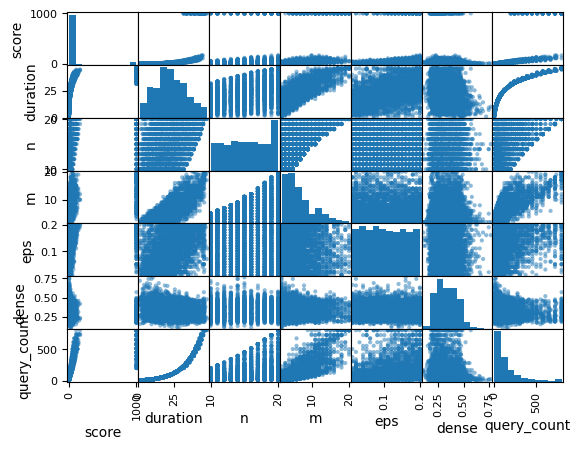

In [336]:
_ = pd.plotting.scatter_matrix(solver_df[num_cols])

In [337]:
def read_input(seed: int):
    with open(f"../tools/in/{seed:04}.txt", "r") as f:
        n, m, eps = f.readline().split()
        n, m, eps = int(n), int(m), float(eps)
        ds = []
        minos = []
        dense = 0
        for _ in range(m):
            s = f.readline().split()
            d, v = int(s[0]), list(map(int, s[1:]))
            v = [(v[2 * i], v[2 * i + 1]) for i in range(d)]
            ds.append(d)
            minos.append(v)
            dense += d
        dense /= n * n

    return n, m, eps, ds, minos, dense

In [338]:
div = 4

ratio_feats = []

for seed in tqdm(range(len(solver_df))):
    n, m, eps, ds, minos, dense = read_input(seed)

    sizes = [(max(map(lambda p: p[0], mino)), max(map(lambda p: p[1], mino))) for mino in minos]

    ratios = []
    for j, mino2 in enumerate(minos):
        s = set(mino2)
        for i, mino1 in enumerate(minos):
            if i <= j:
                continue
            max_cnt = 0
            for di in range(-sizes[i][0], sizes[j][0]):
                for dj in range(-sizes[i][1], sizes[j][1]):
                    cnt = 0
                    for p in mino1:
                        v = (p[0] + di, p[1] + dj)
                        if v in s:
                            cnt += 1
                    max_cnt = max(max_cnt, cnt)
            if max_cnt == len(mino1):
                continue
            ratios.append(max_cnt / len(mino1))

    ratios.sort()
    ratio_ave = sum(ratios) / len(ratios)
    ratio_max = max(ratios)
    # ratio_feat = [ratio_ave, ratio_max] + [ratios[len(ratios) * i // div] for i in range(1, div)]
    ratio_feat = [ratio_max]
    ratio_feats.append(ratio_feat)

100%|██████████| 3000/3000 [00:16<00:00, 184.28it/s]


In [339]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression

df = pd.read_csv("../log/database.csv")
input_df = pd.read_csv("../log/input.csv")
solver_df = pd.merge(df[df.solver_version == SOLVER_VERSION], input_df, how="left", on="input_file")

ratio_cols = [f"ratio_feat_{i}" for i in range(len(ratio_feats[0]))]
ratios_df = pd.DataFrame(ratio_feats, index=solver_df.index, columns=ratio_cols)
solver_df = pd.concat([solver_df, ratios_df], axis=1)
solver_df.head()

,input_file,solver_version,score,duration,query_count,n,m,eps,dense,ratio_feat_0
0,tools/in/0000.txt,data-collection-3,0.707107,3.1395,7,15,2,0.01,0.168889,0.578947
1,tools/in/0001.txt,data-collection-3,6.337479,16.4577,48,13,6,0.04,0.159763,0.800000
2,tools/in/0002.txt,data-collection-3,4.230085,12.1795,30,13,2,0.07,0.402367,0.916667
3,tools/in/0003.txt,data-collection-3,2.356660,9.1322,20,19,2,0.08,0.315789,0.690909
4,tools/in/0004.txt,data-collection-3,25.692689,27.5753,153,16,8,0.14,0.367188,0.900000


In [346]:
solver_df[num_cols + ratio_cols].corr()

,score,duration,n,m,eps,dense,query_count,ratio_feat_0
score,1.000000,0.529787,0.180765,0.430603,0.269256,-0.125514,0.686976,0.079556
duration,0.529787,1.000000,0.467151,0.773140,0.445972,-0.193495,0.885243,0.358583
n,0.180765,0.467151,1.000000,0.574350,-0.029771,0.019270,0.475035,0.274191
m,0.430603,0.773140,0.574350,1.000000,-0.045257,-0.015386,0.773810,0.399619
eps,0.269256,0.445972,-0.029771,-0.045257,1.000000,-0.023946,0.366909,-0.010638
dense,-0.125514,-0.193495,0.019270,-0.015386,-0.023946,1.000000,-0.156580,0.144679
query_count,0.686976,0.885243,0.475035,0.773810,0.366909,-0.156580,1.000000,0.244795
ratio_feat_0,0.079556,0.358583,0.274191,0.399619,-0.010638,0.144679,0.244795,1.000000


In [386]:
alphas = [0.5]

data_df = solver_df[num_cols]
data_df.loc[:, ["target"]] = data_df["query_count"]

data_df = data_df.drop(["score", "duration", "query_count"], axis=1)

feature_cols = []

base_feature_cols = ["n", "m", "eps", "dense"]

# 特徴量
for col in base_feature_cols:
    # feature_cols.append(f"{col}.ln()")
    # data_df.loc[:, [f"{col}.ln()"]] = np.log(data_df[col])

    for alpha in alphas:
        feature_cols.append(f"{col}.powf({alpha})")
        data_df.loc[:, [f"{col}.powf({alpha})"]] = data_df[col] ** alpha

# feature_cols += ratio_cols

for col1 in feature_cols:
    for col2 in feature_cols:
        data_df.loc[:, [f"{col1} * {col2}"]] = data_df[col1] * data_df[col2]
        data_df.loc[:, [f"{col1} / {col2}"]] = data_df[col1] / data_df[col2]

x = data_df.drop(["target"], axis=1)
y = data_df["target"]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

model = Ridge(alpha=1e-2)
model.fit(train_x, train_y)

# print(model.coef_)
# print(model.intercept_)
print(model.score(train_x, train_y))
print(model.score(test_x, test_y))
expr = " + ".join([f"{c:.5} * {t}" for c, t in zip(model.coef_.flatten(), x.columns)]) + f" + {model.intercept_:.5}"
print(expr)
with open("../log/expr.txt", "w") as f:
    f.write(expr + "\n")

0.8808299170963513
0.8703149040851488
-1.478 * n + 62.489 * m + 765.19 * eps + 2.3331 * dense + 176.86 * n.powf(0.5) + -1030.1 * m.powf(0.5) + -1096.0 * eps.powf(0.5) + 622.34 * dense.powf(0.5) + -1.478 * n.powf(0.5) * n.powf(0.5) + 0.0 * n.powf(0.5) / n.powf(0.5) + 5.146 * n.powf(0.5) * m.powf(0.5) + -280.71 * n.powf(0.5) / m.powf(0.5) + 104.75 * n.powf(0.5) * eps.powf(0.5) + 3.2088 * n.powf(0.5) / eps.powf(0.5) + -8.9536 * n.powf(0.5) * dense.powf(0.5) + 22.361 * n.powf(0.5) / dense.powf(0.5) + 5.146 * m.powf(0.5) * n.powf(0.5) + 865.04 * m.powf(0.5) / n.powf(0.5) + 62.489 * m.powf(0.5) * m.powf(0.5) + 0.0 * m.powf(0.5) / m.powf(0.5) + 276.79 * m.powf(0.5) * eps.powf(0.5) + 5.8167 * m.powf(0.5) / eps.powf(0.5) + -26.437 * m.powf(0.5) * dense.powf(0.5) + -14.037 * m.powf(0.5) / dense.powf(0.5) + 104.75 * eps.powf(0.5) * n.powf(0.5) + -540.6 * eps.powf(0.5) / n.powf(0.5) + 276.79 * eps.powf(0.5) * m.powf(0.5) + -373.47 * eps.powf(0.5) / m.powf(0.5) + 765.19 * eps.powf(0.5) * eps.powf(0

   138 183.76197391376564
    30 39.738054020097366
   340 413.4687166455271
   153 79.85305583446171
   670 592.5843824210972
    75 46.38847730106636
   253 163.1591342225321
    92 84.86182739613474
   253 202.23367829185116
    48 76.89312519917917


[-12.047324541463354, 1014.4469464461625]

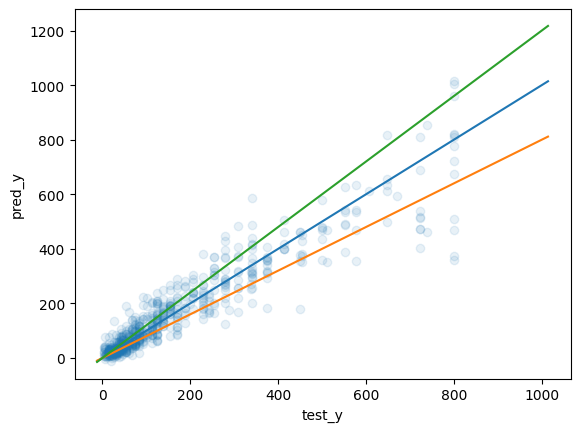

In [387]:
pred_y = model.predict(test_x)
for i in range(10):
    print(f"{test_y.iloc[i]:6} {pred_y[i]}")

plt.scatter(test_y, pred_y, alpha=0.1)
plt.xlabel("test_y")
plt.ylabel("pred_y")
_ = plt.plot([pred_y.min(), pred_y.max()], [pred_y.min(), pred_y.max()])
_ = plt.plot([pred_y.min(), pred_y.max()], [pred_y.min() * 0.8, pred_y.max() * 0.8])
_ = plt.plot([pred_y.min(), pred_y.max()], [pred_y.min() * 1.2, pred_y.max() * 1.2])
[pred_y.min(), pred_y.max()]

In [364]:
import lightgbm as lgb
from sklearn.metrics import r2_score

params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "random_state": 0,
    "verbose": -1
}

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=0)
train_set = lgb.Dataset(train_x, train_y)
valid_set = lgb.Dataset(valid_x, valid_y, reference=train_set)

model = lgb.train(params=params, train_set=train_set, valid_sets=[valid_set], num_boost_round=1000)

pred_y = model.predict(test_x, num_iteration=model.best_iteration)
print(r2_score(test_y, pred_y))

0.864808428918772


[-2.7152936099978056, 862.3440489999116]

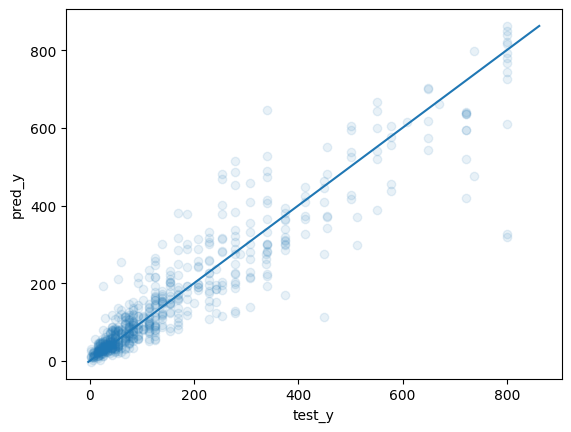

In [344]:
plt.scatter(test_y, pred_y, alpha=0.1)
plt.xlabel("test_y")
plt.ylabel("pred_y")
_ = plt.plot([pred_y.min(), pred_y.max()], [pred_y.min(), pred_y.max()])
[pred_y.min(), pred_y.max()]